## Recommender system

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit import als

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender


Bad key "text.kerning_factor" on line 4 in
C:\Users\Mell\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


### 1.Загрузка и изучение данных

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

In [3]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [4]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [8]:
data['user_id'][data['sales_value'] <= 0].count()

17394

In [9]:
data[data.isnull().any(axis=1)]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc


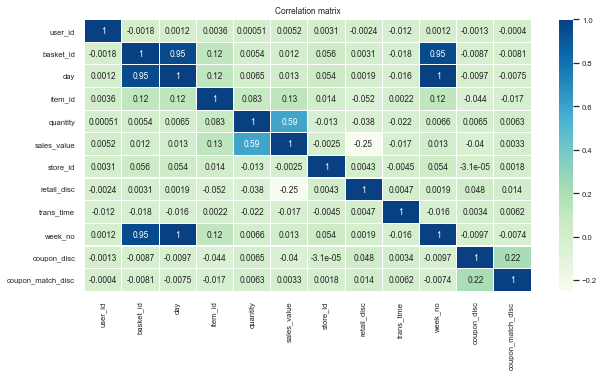

In [10]:
plt.figure(figsize = (10,5))
sns.set(font_scale=0.7)
sns.heatmap(data.corr(), annot=True, linewidths=.2, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Как ввидим есть часть транзакций с нулевой суммой. Из матрицыкорреляций видно что basket_id, day и week_no очень сильно коррелируют. 

### 2.Подготовка обучающих, валидационных и тестовых датасетов

Распределим данные на 3 временных отрезка:

In [11]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

Уникальные пользователи на val и test:

In [12]:
usr_lvl_1 = data_train_lvl_1.user_id.unique()
usr_lvl_2 = data_val_lvl_1.user_id.unique()
usr_lvl_3 = data_val_lvl_2.user_id.unique()
new_lvl_2 = list(set(usr_lvl_2) - set(usr_lvl_1))
new_lvl_3 = list(set(usr_lvl_3) - (set(usr_lvl_1) | set(usr_lvl_2)))

new_to_lvl_2 = list(set(usr_lvl_3) - (set(usr_lvl_2)))

### 3.Prefilter

In [13]:
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


### 4.Feature engineering

**User:**

In [14]:
for i in user_features.columns:
    if user_features[i].nunique() < 15:
        print(f'{i} - {user_features[i].unique()}')

age_desc - ['65+' '45-54' '25-34' '35-44' '19-24' '55-64']
marital_status_code - ['A' 'U' 'B']
income_desc - ['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K']
homeowner_desc - ['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner']
hh_comp_desc - ['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids']
household_size_desc - ['2' '3' '4' '1' '5+']
kid_category_desc - ['None/Unknown' '1' '2' '3+']


In [15]:
user_features['age_desc'].replace({
    '19-24': 21,
    '25-34': 30,
    '35-44': 40,
    '45-54': 50,
    '55-64': 60,
    '65+': 70}, inplace=True)

user_features['marital_status_code'].replace({
    'U': 0,
    'A': 1,
    'B': 2}, inplace=True)

user_features['income_desc'].replace({
    'Under 15K': 10,
    '15-24K': 20,
    '25-34K':30,
    '35-49K': 42,
    '50-74K': 62,
    '75-99K': 87,
    '100-124K': 112,
    '125-149K': 137, 
    '150-174K': 162,
    '175-199K': 187,
    '200-249K': 225,
    '250K+':270}, inplace=True)

user_features['homeowner_desc'].replace({
    'Unknown': 0,
    'Probable Renter': 1,
    'Renter': 2,
    'Probable Owner': 3,
    'Homeowner': 4}, inplace=True)

user_features['hh_comp_desc'].replace({
    'Unknown': 0,
    'Single Male': 1,
    'Single Female': 2,
    '1 Adult Kids': 3,
    '2 Adults Kids': 4,
    '2 Adults No Kids':5},inplace=True)

user_features['household_size_desc'].replace({'5+': 5}, inplace=True) 

In [16]:
user_features['kid_category_desc'].replace({
    'None/Unknown': 0,
    '3+': 3}, inplace=True)

In [17]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,70,1,42,4,5,2,0,1
1,50,1,62,4,5,2,0,7
2,30,0,30,0,4,3,1,8


**Items:**

In [18]:
for i in item_features.columns:
    if item_features[i].nunique() < 15:
        print(f'{i} - {item_features[i].unique()}')

brand - ['National' 'Private']


In [19]:
item_features['brand'].replace({
    'Private': 0,
    'National': 1}, inplace=True)

**Новые признаки основного датасета**

In [20]:
def get_new_features(data_train_lvl_1):
    
    data = data_train_lvl_1.copy()
    
    # день недели совершения транзакции
    data['weekday'] = data['day'] % 7
    new_features = data.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
    new_features.columns = ['user_id', 'item_id', 'median_weekday']
    
    # средний чек корзины 
    df = data.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
    df = df.groupby('user_id')['sales_value'].mean().reset_index()
    df.columns = ['user_id', 'mean_check']
    new_features = new_features.merge(df, on=['user_id'])
    
    # кол-во уникальных товаров для клиента
    df = data.groupby(['user_id'])['item_id'].nunique().reset_index()
    df.columns = ['user_id', 'n_items']
    new_features = new_features.merge(df, on=['user_id'])
    
    # cреднее кол-во дней между покупками
    df = data.groupby('user_id')['day'].nunique().reset_index()
    df['active_interval'] = (data.groupby('user_id')['day'].max() - data.groupby('user_id')['day'].min()) / df['day']
    new_features = new_features.merge(df[['user_id', 'active_interval']], on=['user_id'])        
    
    # кол-во транзакций клиента
    df = data.groupby(['user_id'])['item_id'].count().reset_index()
    df.columns = ['user_id', 'n_transactions']
    new_features = new_features.merge(df, on=['user_id'])
    
    recommender = MainRecommender(data)
    
    # эмбеддинги товаров
    df = recommender.model.item_factors
    n_factors = recommender.model.factors
    ind = list(recommender.id_to_itemid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['item_id'] + ['item_factor_' + str(i + 1) for i in range(n_factors)]
    new_features = new_features.merge(df, on=['item_id'])
    
    # эмбеддинги пользователей
    df = recommender.model.user_factors
    ind = list(recommender.id_to_userid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['user_id'] + ['user_factor_' + str(i + 1) for i in range(n_factors)]
    new_features = new_features.merge(df, on=['user_id'])
    
    return new_features

In [21]:
new_features = get_new_features(data_train_lvl_1)
new_features.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

,user_id,item_id,median_weekday,mean_check,n_items,active_interval,n_transactions,item_factor_1,item_factor_2,item_factor_3,...,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,user_factor_20
0,1,823721,4.0,37.4205,172,NaN,661,0.012302,0.006199,0.012984,...,-8.804082,8.191467,5.382714,10.989359,-12.692255,2.774009,12.01755,-12.482206,4.592954,-6.212889
1,1,823990,6.0,37.4205,172,NaN,661,0.007656,0.009849,0.007397,...,-8.804082,8.191467,5.382714,10.989359,-12.692255,2.774009,12.01755,-12.482206,4.592954,-6.212889


### 5.Модель первого уровня

In [22]:
def get_candidates(data_train_lvl_1, data_train_lvl_2, N, new_to_lvl_2):
    recommender = MainRecommender(data_train_lvl_1)

    users_lvl_1 = data_train_lvl_1['user_id'].unique()
    users_lvl_2 = data_train_lvl_2['user_id'].unique().tolist()
    if new_to_lvl_2:
        users_lvl_2 += new_to_lvl_2

    current_users = list(set(users_lvl_2) & set(users_lvl_1))    
    new_users = list(set(users_lvl_2) - set(users_lvl_1))

    df = pd.DataFrame(users_lvl_2, columns=['user_id'])
    cond_1 = df['user_id'].isin(current_users)
    df.loc[cond_1, 'candidates'] = df.loc[cond_1, 'user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N))

    if new_users:
        cond_2 = df['user_id'].isin(new_users)
        df.loc[cond_2, 'candidates'] = df.loc[cond_2, 'user_id'].apply(
            lambda x: recommender.overall_top_purchases[:N])
        
    return df

In [23]:
N = 250
users_lvl_2 = get_candidates(data_train_lvl_1, data_train_lvl_2, N, new_to_lvl_2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame({'user_id': users_lvl_2['user_id'].values.repeat(N),
                       'item_id': np.concatenate(users_lvl_2['candidates'].values)})

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)
    
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(new_features, on=['user_id', 'item_id'], how='left')

In [25]:
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,user_factor_20
0,2070,1105426,0.0,69,DELI,0,SANDWICHES,SANDWICHES - (COLD),,50.0,...,-2.979443,-1.653393,-9.315745,7.556645,1.646447,0.444025,9.586232,4.456331,15.806397,-3.23213
1,2070,1097350,0.0,2468,GROCERY,1,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2070,879194,0.0,69,DRUG GM,0,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,50.0,...,-2.979443,-1.653393,-9.315745,7.556645,1.646447,0.444025,9.586232,4.456331,15.806397,-3.23213


### 6.LightGBM

In [26]:
curr_features = targets_lvl_2.columns.to_list()
list_ = ['target', 'department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
         'household_size_desc', 'kid_category_desc']
for i in list_:
    curr_features.remove(i)

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(targets_lvl_2[curr_features].fillna(0),
                                                          targets_lvl_2[['target']],
                                                          test_size=0.2, random_state=33,
                                                          stratify=targets_lvl_2[['target']])

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
params_lgb = {"boosting_type": "gbdt",
              "objective": "binary", 
              "metric": "auc",
              "num_boost_round": 10000,
              "learning_rate": 0.1,
              "class_weight": 'balanced',
              "max_depth": 10,
              "n_estimators": 5000,
              "n_jobs": 6,
              "seed": 12} 

model_lgb = lgb.train(params=params_lgb,
                train_set=dtrain,  
                valid_sets=[dtrain, dvalid],
                verbose_eval=1000,
                early_stopping_rounds=20)

C:\Users\Mell\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Mell\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 25134, number of negative: 437686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12001
[LightGBM] [Info] Number of data points in the train set: 462820, number of used features: 54
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [bi

In [28]:
pred_lgb_train = model_lgb.predict(targets_lvl_2[curr_features].fillna(0))

In [29]:
roc_auc_score(targets_lvl_2['target'], pred_lgb_train)

0.9455462504239673

In [30]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

df = targets_lvl_2[['user_id', 'item_id']]
df['predictions'] = pred_lgb_train

df = df.groupby(['user_id', 'item_id'])['predictions'].median().reset_index()
df = df.sort_values(['predictions'], ascending=False).groupby(['user_id']).head(5)

df = df.groupby('user_id')['item_id'].unique().reset_index()
df.columns = ['user_id', 'lgb_recommendations']

result = result.merge(df, on='user_id', how='left')

C:\Users\Mell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [31]:
result.head(2)

,user_id,actual,lgb_recommendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9527558, 9297615, 940947, 1082212, 872137]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5569230, 983584, 885697, 899624]"


### 7.Precision_at_k

In [32]:
result.apply(lambda row: precision_at_k(row['lgb_recommendations'], row['actual'], 5), axis=1).mean()

0.2781586679725759

### 8.Сохранение результатов

In [37]:
result

,user_id,actual,lgb_recommendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9527558, 9297615, 940947, 1082212, 872137]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5569230, 983584, 885697, 899624]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1098844, 878996, 1024306, 900802]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1126899, 1106523, 993638, 1122358, 1029743]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1029743, 872137, 1070820, 1090507, 12302069]"
...,...,...,...
2037,2496,[6534178],"[1106523, 933835, 899624, 5568378, 1056509]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1051323, 1102207, 900802, 1135834, 1010950]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1070820, 1106523, 1100379, 896074, 907993]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[1070820, 5568378, 846417, 899624, 1123022]"


In [38]:
df = result[['user_id', 'lgb_recommendations']].copy()
df.to_csv('predictions.csv', index=False)
df.head(2)

,user_id,lgb_recommendations
0,1,"[9527558, 9297615, 940947, 1082212, 872137]"
1,3,"[1106523, 5569230, 983584, 885697, 899624]"
